In [1]:
import os
import matplotlib.pyplot as plt
from statistics import mean
from math import log
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from adjustText import adjust_text
from collections import defaultdict

dir = '/Users/k/Docs/School/Tuebingen/Thesis/iscl-thesis/2024_corpora/'
files = [os.path.join(dir, file) for file in os.listdir(dir) if file.endswith('.txt')]

languages = {
    'id': 'nat', 
    'tl': 'nat', 
    'tr': 'nat', 
    'en': 'nat', 
    'de': 'nat',
    'fr': 'nat',
    'eo': 'con',
    'lfn': 'con',
    'ia': 'con',
    'io': 'con',
    'pl': 'nat',
    'vi': 'nat',
    'fi': 'nat',
    'it': 'nat',
    'af': 'nat',
    'nl': 'nat',
    'es': 'nat',
    'oc': 'nat',
    'da': 'nat',
    'sv': 'nat',
    'is': 'nat',
    'hu': 'nat',
    'vo': 'con',
    'avk': 'con'
    }

TTR and MATTR

In [2]:
# TTR
def calculate_ttr(file):
    
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
    f.close()
    
    tokens = text.split()
    total_tokens = len(tokens)
    types = set(tokens)
    total_types = len(types)
    ttr = (total_types / total_tokens) * 100
    return ttr

ttr_values = {}
    
# MATTR
def calculate_mattr(file, window_size):
    
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
    f.close()
    
    tokens = text.split()
    total_tokens = len(tokens)
    
    ttr_values = []
    for i in range(total_tokens - window_size + 1):
        window = tokens[i:i + window_size]
        types = set(window)
        total_types = len(types)
        ttr = total_types / window_size
        ttr_values.append(ttr)

    mattr = sum(ttr_values) / len(ttr_values)
    return mattr

mattr_values = {}
window_size = 100  

Character and Word Distribution Entropies

In [3]:
# Char Dist Entropy
def log2(number):
    return log(number) / log(2)

def calculate_char_entropy(file):
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
    f.close()
    
    char_freq = {}
    for char in text:
        if char in char_freq:
            char_freq[char] += 1
        else:
            char_freq[char] = 1
            
    length_sum = 0.0
    for char in char_freq:
        p = float(char_freq[char]) / len(text)
        length_sum += p * log2(p)
        
    return -length_sum

char_entropies = {}
    
# Word Dist Entropy
def log2(number):
    return log(number) / log(2)

def calculate_word_entropy(file):
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
    f.close()
    
    word_freq = {}
    total_words = 0
    for word in text.split():
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1
        total_words += 1
            
    length_sum = 0.0
    for word in word_freq:
        p = float(word_freq[word]) / total_words
        length_sum += p * log2(p)
        
    return -length_sum

word_entropies = {}


Average Word/Sentence Lengths

In [4]:
def calculate_avg_word_len(file):
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
    f.close()
    words = text.split()    
    return (sum(len(word) for word in words)) / len(words)

def calculate_avg_sentence_len(file):
    with open(file, 'r', encoding='utf-8') as f:
        text = f.readlines()
    f.close()
    
    # total_words = 0
    # total_characters = 0
    # for sentence in text:
    #     words = sentence.split()
    #     total_words += len(words)
    #     total_characters += sum(len(word) for word in words)
    
    # return total_words / len(text), total_characters / len(text)
    
    sentence_lengths = []
    for sentence in text:
        words = sentence.split()
        sentence_lengths.append(len(words))
        
    return mean(sentence_lengths)

avg_word_length = {}
avg_sentence_length = {}

for file in files:
    lang = os.path.splitext(os.path.basename(file))[0].split('_')[0]
    ttr_values[lang] = calculate_ttr(file)
    mattr_values[lang] = calculate_mattr(file, window_size)
    char_entropies[lang] = calculate_char_entropy(file)
    word_entropies[lang] = calculate_word_entropy(file)
    avg_word_length[lang] = calculate_avg_word_len(file)
    avg_sentence_length[lang] = calculate_avg_sentence_len(file)

Creating Features Dataframe

In [5]:
calculations = {
    'Avg Word Length': avg_word_length,
    'Avg Sentence Length': avg_sentence_length,
    'TTR': ttr_values,
    'MATTR': mattr_values,
    'Char Dist Entr': char_entropies,
    'Word Dist Entr': word_entropies
}
for label, dic in calculations.items():
    calculations[label] = pd.Series(dic)
temp = pd.DataFrame(calculations)
calculations_df = temp.copy()
calculations_df['corpus'] = calculations_df.index
calculations_df = calculations_df[['corpus', 'Avg Word Length', 'Avg Sentence Length', 'TTR', 'MATTR', 'Char Dist Entr', 'Word Dist Entr']]
# Getting the validation loss for the last epoch and last step for each language from the torch_rnn_results.csv file (for text entropy) and using val_perplexity as entropy value 
torch_rnn_df = pd.read_csv('./results/torch_rnn_results.csv', index_col=0)
dfs = []
for lang in languages:
    temp = torch_rnn_df.loc[(torch_rnn_df['epoch'] == 20) & (torch_rnn_df['corpus'] == lang)]
    temp = temp[temp['step'] == temp['step'].max()]
    dfs.append(temp)
ref = pd.concat(dfs)
text_entropy_df = ref[['corpus', 'val_perplexity']]
text_entropy_df.insert(1, 'Type', ref['corpus'].apply(lambda x: languages.get(x)))
text_entropy_df.rename(columns={'val_perplexity':'Text Entr'}, inplace=True)
reverse_lex_entropy_df, lex_entropy_df = pd.read_csv('./results/reverse_lex_entropy_hist_df.csv'), pd.read_csv('./results/lex_entropy_hist_df.csv')
reverse_lex_entropy_df.rename(columns={'val_loss':'Rev Lex Entr'}, inplace=True)
lex_entropy_df.rename(columns={'val_loss':'Lex Entr'}, inplace=True)
features_df = pd.merge(text_entropy_df, calculations_df, on='corpus', how='left')
features_df = pd.merge(features_df, reverse_lex_entropy_df[['corpus', 'Rev Lex Entr']], on='corpus', how='left')
features_df = pd.merge(features_df, lex_entropy_df[['corpus', 'Lex Entr']], on='corpus', how='left')
features_df.rename(columns={'corpus':'Corpus'}, inplace=True)
features_df.to_csv('./results/features_df.csv', columns=['Corpus', 'Type', 'Avg Word Length', 'Avg Sentence Length', 'TTR', 'MATTR', 'Char Dist Entr', 'Word Dist Entr', 'Text Entr', 'Lex Entr', 'Rev Lex Entr'], index=False)
print(features_df)

   Corpus Type  Text Entr  Avg Word Length  Avg Sentence Length        TTR  \
0      id  nat   3.517539         6.173187            18.164432   5.781932   
1      tl  nat   3.824064         5.119253            21.101625   7.593148   
2      tr  nat   4.113557         6.629588            14.458380  14.097413   
3      en  nat   4.115928         5.087280            21.301075   6.078659   
4      de  nat   3.964652         6.205757            16.907410  12.127552   
5      fr  nat   3.496586         5.159560            23.120339   7.461471   
6      eo  con   3.857892         5.174506            18.909085  10.708038   
7     lfn  con   3.935966         4.220976            19.531596   5.063124   
8      ia  con   3.336037         5.050308            19.547488   6.880044   
9      io  con   1.156939         4.593711            14.483861   3.432594   
10     pl  nat   4.316066         6.247614            14.950804  14.889753   
11     vi  nat   4.000555         3.498411            29.834620 

/var/folders/1w/_90xn6_52fq9d37y9_7snxr40000gn/T/ipykernel_17372/2676000107.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_entropy_df.rename(columns={'val_perplexity':'Text Entr'}, inplace=True)


PCA of Calculations

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(ar

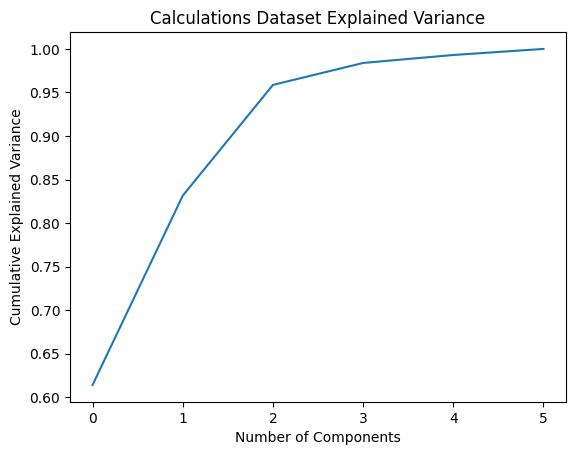

In [6]:
# DETERMINING NUMBER OF PRINCIPLE COMPONENTS TO USE FOR CALCULATIONS DATA (from https://medium.com/analytics-vidhya/feature-extraction-techniques-pca-lda-and-t-sne-df0459c723aa)

numeric_df = calculations_df.select_dtypes(include='number')

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

pca = PCA()
pca.fit_transform(scaled_data)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')  # for each component
plt.title('Calculations Dataset Explained Variance')
plt.show(block=True)

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(ar

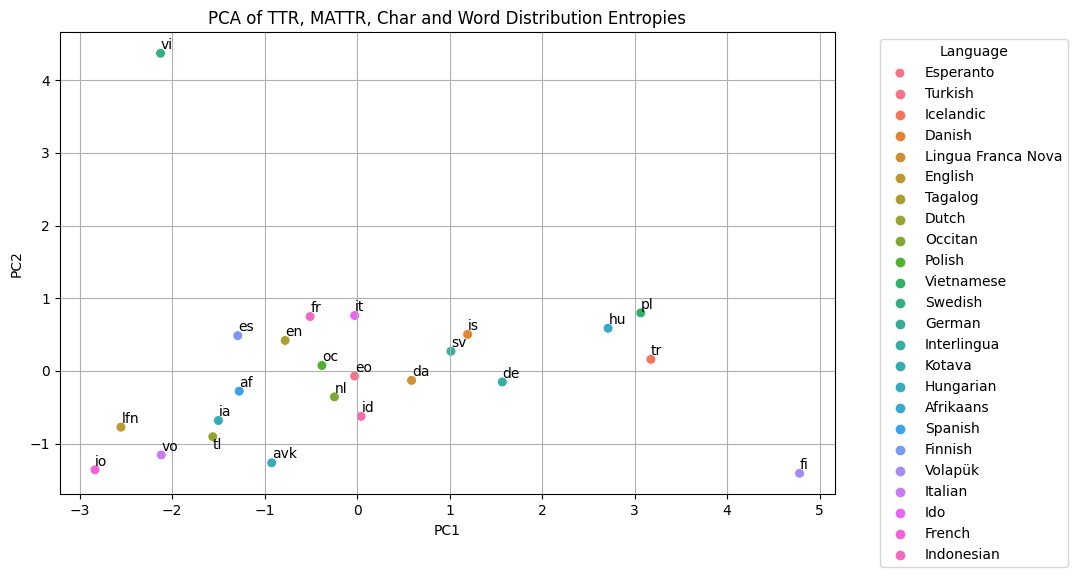

In [7]:
# TESTING #

numeric_df = calculations_df.select_dtypes(include='number')

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df.index = calculations_df.index

# print(pca_df)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue=pca_df.index, s=50)

texts = []
for i, language in enumerate(pca_df.index):
    texts.append(plt.annotate(language, (pca_df['PC1'][i], pca_df['PC2'][i])))
    
adjust_text(texts)

lang_labels = {
    'sv': 'Swedish', 
    'id': 'Indonesian', 
    'eo': 'Esperanto',
    'is': 'Icelandic',
    'pl': 'Polish',
    'da': 'Danish',
    'tl': 'Tagalog',
    'ia': 'Interlingua',
    'fi': 'Finnish',
    'vi': 'Vietnamese',
    'hu': 'Hungarian',
    'nl': 'Dutch',
    'lfn': 'Lingua Franca Nova',
    'es': 'Spanish',
    'io': 'Ido',
    'af': 'Afrikaans',
    'fr': 'French',
    'it': 'Italian',
    'tr': 'Turkish',
    'de': 'German',
    'oc': 'Occitan',
    'en': 'English',
    'vo': 'Volapük',
    'avk': 'Kotava'
    }
legend_labels = [lang_labels[abb] for abb in pca_df.index]
    
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of TTR, MATTR, Char and Word Distribution Entropies')
plt.grid(True)
plt.legend(title='Language', labels=legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
plt.show()

PCA of All Features

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(ar

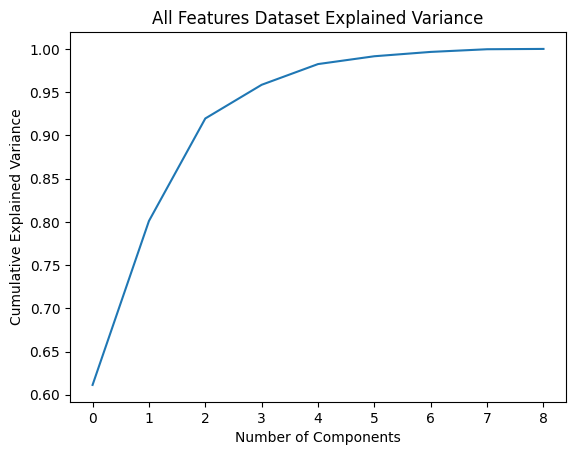

In [8]:
# DETERMINING NUMBER OF PRINCIPLE COMPONENTS TO USE FOR ALL FEATURES DATA (from https://medium.com/analytics-vidhya/feature-extraction-techniques-pca-lda-and-t-sne-df0459c723aa)

numeric_df2 = features_df.select_dtypes(include='number')

scaler2 = StandardScaler()
scaled_data2 = scaler2.fit_transform(numeric_df2)

pca2 = PCA()
pca2.fit_transform(scaled_data2)

plt.figure()
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')  # for each component
plt.title('All Features Dataset Explained Variance')
plt.show(block=True)

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(ar

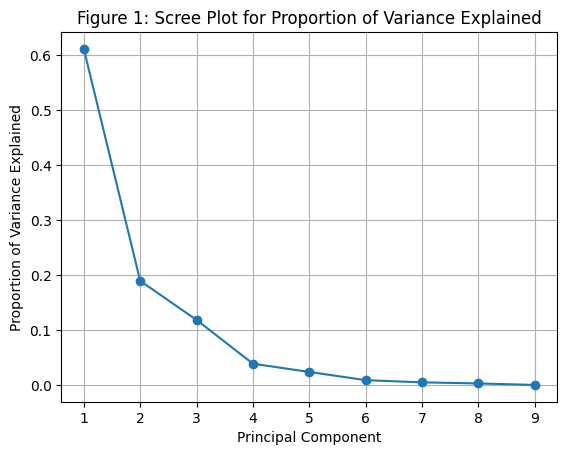

In [9]:
# DETERMINING NUMBER OF PRINCIPLE COMPONENTS TO USE FOR ALL FEATURES DATA (from https://statisticsglobe.com/scree-plot-pca-python)
# Without considering Kaiser's rule

numeric_df2 = features_df.select_dtypes(include='number')

scaler2 = StandardScaler()
scaled_data2 = scaler2.fit_transform(numeric_df2)
pca2 = PCA()
pca2.fit_transform(scaled_data2)

eigenvalues = pca2.explained_variance_
prop_var = eigenvalues / np.sum(eigenvalues)

plt.figure()
plt.plot(np.arange(1, len(prop_var)+1), 
                   prop_var, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Figure 1: Scree Plot for Proportion of Variance Explained')
plt.grid(True)

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(ar

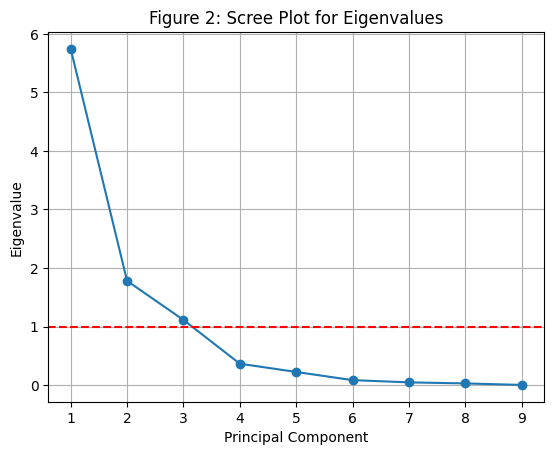

In [10]:
# DETERMINING NUMBER OF PRINCIPLE COMPONENTS TO USE FOR ALL FEATURES DATA (from https://statisticsglobe.com/scree-plot-pca-python)
# With considering Kaiser's rule

numeric_df2 = features_df.select_dtypes(include='number')

scaler2 = StandardScaler()
scaled_data2 = scaler2.fit_transform(numeric_df2)
pca2 = PCA()
pca2.fit_transform(scaled_data2)

eigenvalues = pca2.explained_variance_
prop_var = eigenvalues / np.sum(eigenvalues)

plt.figure()
plt.plot(np.arange(1, len(eigenvalues)+1), 
         eigenvalues, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Figure 2: Scree Plot for Eigenvalues',)
plt.axhline(y=1, color='r', 
            linestyle='--')
plt.grid(True)

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(ar

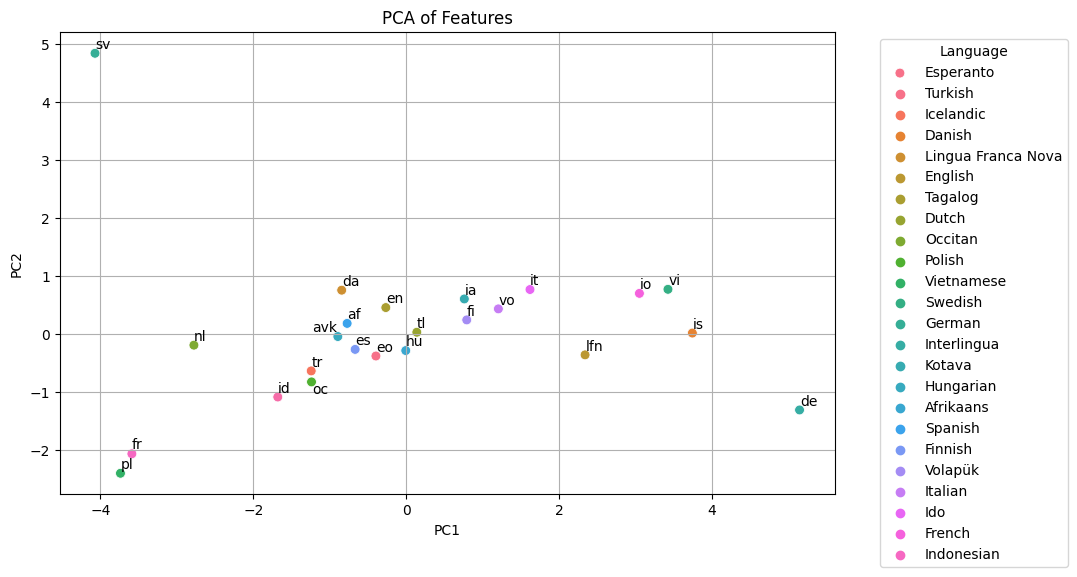

In [11]:
numeric_df3 = features_df.select_dtypes(include='number')

scaler3 = StandardScaler()
scaled_data3 = scaler.fit_transform(numeric_df3)

pca3 = PCA(n_components=2)
pca_result3 = pca3.fit_transform(scaled_data3)

pca_df3 = pd.DataFrame(pca_result3, columns=['PC1', 'PC2'])
pca_df3.index = calculations_df.index

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df3, hue=pca_df3.index, s=50)

texts = []
for i, language in enumerate(pca_df3.index):
    texts.append(plt.annotate(language, (pca_df3['PC1'][i], pca_df3['PC2'][i])))
    
adjust_text(texts)

lang_labels = {
    'sv': 'Swedish', 
    'id': 'Indonesian', 
    'eo': 'Esperanto',
    'is': 'Icelandic',
    'pl': 'Polish',
    'da': 'Danish',
    'tl': 'Tagalog',
    'ia': 'Interlingua',
    'fi': 'Finnish',
    'vi': 'Vietnamese',
    'hu': 'Hungarian',
    'nl': 'Dutch',
    'lfn': 'Lingua Franca Nova',
    'es': 'Spanish',
    'io': 'Ido',
    'af': 'Afrikaans',
    'fr': 'French',
    'it': 'Italian',
    'tr': 'Turkish',
    'de': 'German',
    'oc': 'Occitan',
    'en': 'English',
    'vo': 'Volapük',
    'avk': 'Kotava'
    }
legend_labels3 = [lang_labels[abb] for abb in pca_df3.index]
    
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Features')
plt.grid(True)
plt.legend(title='Language', labels=legend_labels3, bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
plt.show()

Variance Ratio

In [12]:
# Follow https://medium.com/analytics-vidhya/feature-extraction-techniques-pca-lda-and-t-sne-df0459c723aa for plotting cumulative explained variance ratio

In [13]:
pca.explained_variance_ratio_

array([0.61409205, 0.21738354])

In [43]:
# # PCA on all feature dimensions
# all_dim_df = pd.read_csv('./results/features_df.csv')
# data = all_dim_df.drop(columns=['Type'])
# data = data.set_index('Corpus')
# data.index.names = [None]

# # Why scale the data? Why fit_transform?
# scaler2 = StandardScaler()
# scaled_data2 = scaler2.fit_transform(data)

# pca2 = PCA(n_components=0.95)
# pca_result2 = pca2.fit_transform(scaled_data2)

# pca_df2 = pd.DataFrame(pca_result2, columns=['PC1', 'PC2'])
# pca_df2.index = data.index

# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='PC1', y='PC2', data=pca_df2, hue=pca_df2.index, s=50)

# texts = []
# for i, language in enumerate(pca_df2.index):
#     texts.append(plt.annotate(language, (pca_df2['PC1'][i], pca_df2['PC2'][i])))
    
# adjust_text(texts)

# lang_labels = {
#     'sv': 'Swedish', 
#     'id': 'Indonesian', 
#     'eo': 'Esperanto',
#     'is': 'Icelandic',
#     'pl': 'Polish',
#     'da': 'Danish',
#     'tl': 'Tagalog',
#     'ia': 'Interlingua',
#     'fi': 'Finnish',
#     'vi': 'Vietnamese',
#     'hu': 'Hungarian',
#     'nl': 'Dutch',
#     'lfn': 'Lingua Franca Nova',
#     'es': 'Spanish',
#     'io': 'Ido',
#     'af': 'Afrikaans',
#     'fr': 'French',
#     'it': 'Italian',
#     'tr': 'Turkish',
#     'de': 'German',
#     'oc': 'Occitan',
#     'en': 'English',
#     'vo': 'Volapük',
#     'avk': 'Kotava'
#     }
# legend_labels = [lang_labels[abb] for abb in pca_df2.index]
    
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.title('PCA Visualization of Language Metrics, extended')
# plt.grid(True)
# plt.legend(title='Language', labels=legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')
# # plt.tight_layout()
# plt.show()

Morphological Complexity (Morfessor)

In [ ]:
# Testing...
segmentations = open('./segmodels/en_model.segm', 'r', encoding='utf-8').read().splitlines()[1:]
segmentations = [line.lstrip('1').strip() for line in segmentations]
print(segmentations)

In [ ]:
from collections import defaultdict
import os

segmodels_dir = '/Users/k/Docs/School/Tuebingen/Thesis/iscl-thesis/segmodels'
segmodels = [os.path.join(segmodels_dir, file) for file in os.listdir(segmodels_dir) if file.endswith('.segm')]

# Average number of forms per lemma
# lemmas_forms_dict = defaultdict(list)
# for word in segmentations:
#     segments = word.split(' + ')
#     lemmas_forms_dict[max(segments, key=len)].extend([m for m in segments if m != max(segments, key=len)])

# for i, (k, v) in enumerate(lemmas_forms_dict.items()):
#     if i == 5:  
#         break
#     print(f"{k}: {v}")

# Morpheme TTR
# types = set([word.split(' + ') for word in segmentations])
# types = {s for seg in [word.split(' + ') for word in segmentations] for s in seg if len(s) != len(max(seg, key=len))}
# print(types)

for file in segmodels:
    data = open(file, 'r', encoding='utf-8').read().splitlines()[1:]
    segmentations = [line.lstrip('1').strip() for line in data]
    # segmentations = [line.split(' + ') for line in segmentations]
    print(segmentations[:2])
    # lang = os.path.splitext(os.path.basename(file))[0].split('_')[0]
    # segmentations = [line.split(' + ') for line in segmentations]
    # morphemes = [n[1:] for n in segmentations if n[1:]]
    # lemmas = [n[0] for n in segmentations]
    # lemmas_and_segmentations_dict = defaultdict(list)
    # for seg in segmentations:
    #     lemma = seg[0]
    #     if seg[1:]:
    #         lemmas_and_segmentations_dict[lemma].append(seg[1:])
    # lemmas_and_segmentations = [(lemma, segmentations) for lemma, segmentations in lemmas_and_segmentations_dict.items()]
    # n_morphs = len(set(morphemes))
    # avg_seg_per_word = sum(len(forms) for forms in segmentations) / len(segmentations)
    # n_forms_per_lemma = {i:lemmas.count(i) for i in set(lemmas)}
    # lemma_prob_dist = {}

In [ ]:
segmentations = [line.split(' + ') for line in text]
lemmas = [n[0] for n in segmentations]
forms_per_lemma = {i:lemmas.count(i) for i in set(lemmas)}
lemmas_and_segmentations_dict = defaultdict(list)
for seg in segmentations:
    lemma = seg[0]
    if seg[1:]:
        lemmas_and_segmentations_dict[lemma].append(seg[1:])
lemmas_and_segmentations = [(lemma, segmentations) for lemma, segmentations in lemmas_and_segmentations_dict.items()]
segmentations

In [ ]:
analysis = {}
morph_df = pd.DataFrame()

for file in os.listdir('./segmodels'):
    text = open(file, 'r', encoding='utf-8').read().splitlines()[1:]
    text = [line.lstrip('1').strip() for line in text]
    language = os.path.splitext(os.path.basename(file))[0].split('_')[0]
    segmentations = [line.split(' + ') for line in text]
    morphemes = [n[1:] for n in segmentations if n[1:]]
    lemmas = [n[0] for n in segmentations]
    lemmas_and_segmentations_dict = defaultdict(list)
    for seg in segmentations:
        lemma = seg[0]
        if seg[1:]:
            lemmas_and_segmentations_dict[lemma].append(seg[1:])
    lemmas_and_segmentations = [(lemma, segmentations) for lemma, segmentations in lemmas_and_segmentations_dict.items()]
    n_morphs = len(set(morphemes))
    avg_seg_per_word = sum(len(forms) for forms in segmentations) / len(segmentations)
    n_forms_per_lemma = {i:lemmas.count(i) for i in set(lemmas)}
    lemma_prob_dist = {}

Frequency Distribution (Char and Word)

In [ ]:
import os, torch, torch.nn as nn, re, random, pandas as pd, numpy as np, seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from scipy import stats

In [ ]:
# corpora = ['Esperanto.txt', 'Interlingua.txt', 'Lojban.txt', 'Lfn.txt', 'Russian.txt', 'English.txt', 'German.txt', 'Japanese.txt', 'Mandarin.txt', 'Hindi.txt']
# natural = ['Russian.txt', 'German.txt', 'English.txt', 'Japanese.txt', 'Mandarin.txt', 'Hindi.txt']
# constructed = ['Esperanto.txt', 'Interlingua.txt', 'Lojban.txt', 'Lfn.txt']

In [ ]:
dir = '/Users/k/Docs/School/Tuebingen/Thesis/iscl-thesis/2024_corpora/'
corpora = [os.path.join(dir, file) for file in os.listdir(dir) if file.endswith('.txt')]
constructed = ['eo_wiki_cleaned.txt', 'lfn_wiki_cleaned.txt', 'ia_wiki_cleaned.txt', 'io_wiki_cleaned.txt', 'avk_wiki_cleaned.txt', 'vo_wiki_cleaned.txt']

In [ ]:
# Character Frequency Distribution

def char_frequency(corpus, sequences=None, n_gram=None):
    with open(corpus) as f:
        if sequences:
            text = f.read().splitlines()[:int(sequences / len(corpora))]
            print(f'{len(text)} lines of text from {corpus[:(len(corpus)-4)]} corpus.')
        else:
            text = f.read().splitlines()
        f.close()
    df = pd.DataFrame(columns=['Char', 'Act_Freq', 'Rel_Freq', 'Zipf_Freq', 'Norm_Freq'])
    if n_gram == 'uni':
        frequencies = Counter(char for line in text for char in line if char.split())
    elif n_gram == 'bi':
        frequencies = Counter(word[i:i+2] for line in text for word in line.split() for i in range(len(word)-1))
    else:
        frequencies = Counter(char for line in text for char in line if char.split())   
    frequencies = frequencies.most_common()
    top_frequency = frequencies[0][1]
    relative_freq_sum = sum([1/i for i in range(1, len(frequencies)+1)])
    for index, item in enumerate(frequencies, start=1):
        relative_freq = 1/index
        zipf_freq = top_frequency * (1/index)
        normalized_freq = relative_freq / relative_freq_sum
        df.loc[index] = [item[0], item[1], relative_freq, zipf_freq, normalized_freq]
    return df


def char_vocabulary(corpus=None, df=None, sequences=None, n_gram=None):
    if corpus:
        df = char_frequency(corpus, sequences=sequences, n_gram=n_gram)
    return {char: freq for char, freq in zip(df['Char'], df['Act_Freq'])}


def plot_char_dist(df, chars=None):
    if chars: df = df.head(chars)
    plt.figure(figsize=(10, 10))
    plt.ylabel('Zipf Frequency')
    plt.xlabel('Char')
    plt.xticks(rotation=90)
    plt.bar(df['Char'], df['Zipf_Freq'])
    plt.show()
    
    
def corpus_lengths(corpora):
    lengths = {}
    for file in corpora:
        with open(file, 'r', encoding='utf-8') as f:
            data = f.read().splitlines()
            f.close()
        lengths[f'{file.split(".")[0]}'] = len(data)
    return lengths


def vocab_sizes(corpora):
    sizes = {}
    for file in corpora:
        vocab = char_vocabulary(corpus=file, df=None, limit=None)
        sizes[f'{file.split(".")[0]}'] = len(vocab)
    return sizes
    
    
def obfuscate_label_text(corpus, vocab, sequences=None, classification=None):
    with open(corpus, 'r', encoding='utf-8') as f:
        if sequences:
            text = f.read().splitlines()[:int(sequences / len(corpora))]
        else:
            text = f.read().splitlines()
        f.close()
        # Char-based frequency mapping of characters in each string    
        mapping = {value: chr(97 + i) for i, value in enumerate(vocab.values())}
        vocab = {k: mapping[v] for k, v in vocab.items()}
        table = str.maketrans(vocab)
        # Labeling for binary classification
        if classification:
            if classification == 'binary':
                if corpus in constructed:
                    label = [0] * len(text)
                else:
                    label = [1] * len(text)
            # Labeling for multi-classification
            elif classification == 'multi':
                label = [corpora.index(corpus)] * len(text)
            text = list(zip(text, label))
            obfuscated = [(line[0].translate(table), line[1]) for line in text]
        obfuscated = [line.translate(table) for line in text]
        f.close()
    return obfuscated


# def one_hot_encode(data, vocab):
#     seq_length = max(len(line[0] for line in data))
#     string_encoded = np.zeros((seq_length, len(vocab)), dtype=np.float32)
#     for string, label in data:
#         for i, char in enumerate(string):
#             if i >= seq_length:
#                 break
#             string_encoded[i][vocab[char]] = 1
#         label_encoded = np.array([label], dtype=np.int64)
#     return string_encoded, label_encoded


def preprocess_text(corpora, sequences=None, classification=None, n_gram=None):
    data = []
    for corpus in corpora:
        df = char_frequency(corpus=corpus, sequences=sequences, n_gram=None)
        vocab = char_vocabulary(df=df)
        data.extend(obfuscate_label_text(corpus=corpus, vocab=vocab, sequences=sequences, classification=classification))
    return data

In [ ]:
df = char_frequency('../current_corpora/de_wiki_cleaned.txt', n_gram='bi')
df = df.head(20)
plot_char_dist(df)

In [ ]:
cdf = df['Act_Freq'].cumsum() / df['Act_Freq'].sum()
a = 1.5
null_hypothesis = 'zipf'
zipf_dist = stats.zipf(a, loc=1)
zipf_cdf = zipf_dist.cdf(range(1, len(df) + 1))
test_statistic, p_value = stats.kstest(cdf, zipf_cdf)
print(p_value)

Char Embeddings: Char2Vec (from https://github.com/sonlamho/Char2Vec/tree/master)

In [ ]:
from Char2Vec.char2vec.utils import *
from Char2Vec.char2vec.embed import *

In [ ]:
corpus_path = '/Users/k/Docs/School/Tuebingen/Thesis/iscl-thesis/current_corpora/en_wiki_extractor.txt'
alpha = 'abcdefghijklmnopqrstuvwxyz '

In [ ]:
m = Char2Vec(corpus_path, config=CONFIG, alphabet=alpha, unk='~')
m.train()

In [ ]:
# Visualize Char Embeddings
def scatter2d_with_annotation(arr, text, xcol=0, ycol=1, fontsize=7, show=False, **kwargs):
    
    assert len(arr)==len(text)
    fig, ax = plt.subplots(**kwargs)
    xarr = arr[:, xcol]
    yarr = arr[:, ycol]
    plt_texts = []
    
    for i in range(len(text)):
        plt.scatter(xarr[i], yarr[i])
        plt_texts.append(plt.text(xarr[i], yarr[i], text[i], fontsize=fontsize))
        
    if show:
        plt.show()
    return fig, ax

# Char embedding matrix U
U = m.U_

p = PCA()

In [ ]:
U2 = p.fit_transform(U)
texts = m._tokenizer.alphabet + [m._tokenizer.unk]
fig, ax = scatter2d_with_annotation(
            U2, [s.upper() for s in texts],
            0,1,
            figsize=(8,5), fontsize=13)
plt.title('PCA of Character embeddings, Dim-0 vs Dim-1')
plt.show()

In [ ]:
U3 = TSNE(n_components=2, perplexity=5).fit_transform(U)
fig, ax = scatter2d_with_annotation(
            U3, [s.upper() for s in texts],
            0,1,
            figsize=(8,5), fontsize=13)
plt.title('T-SNE of Character embeddings, Perplexity=5')
plt.show()